# MSc in Data Analytics
# Sentiment Analysis Assignment - STEP 2

Assessment Task
Students are advised to review and adhere to the submission requirements documented after the assessment task.  
In this continuous assessment, You are required to identify and carry out an analysis of a large dataset gleaned from the twitter API. Instructions for accessing the data can be found here  
https://datascienceparichay.com/article/get-data-from-twitter-api-in-python-step-by-step-guide/  
https://www.toptal.com/apache/apache-spark-streaming-twitter  
OR You may use the data held here:  
https://archive.org/details/twitterstream?sort=-publicdate  
You must collect at least 1 year's tweets on a topic, this data should be stored as requested below, and you are then required to analyse any change sentiment that occurs over the time period that you have selected.  
Following your analysis, you are then required to make a time series forecast of the sentiment at 1 week, 1 month and 3 months going forward. This forecast must be displayed as a dynamic dashboard.   

### Assignment
Topic: vaccine

this notebook will read the dataset containing only the tweeets related to vaccine.  
The dataset represent tweets from June 2020 until May 2021. **The dataset was downloaded from the link https://archive.org/details/twitterstream?sort=-publicdate**  


## Perform Sentiment Analysis

In [1]:
import findspark
findspark.init()

In [87]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
import pyspark.sql.functions as F

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd

import json, os

In [3]:
# Create the Spark Context

spark = SparkSession \
    .builder \
    .appName("sba22243-sentiment") \
    .config("spark.sql.debug.maxToStringFields", 100) \
    .config("spark.mongodb.input.uri", "mongodb://192.168.0.107/sba22243.vaccine") \
    .config("spark.mongodb.output.uri", "mongodb://192.168.0.107/sba22243.vaccine") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.2') \
    .getOrCreate()
sqlContext = spark._wrapped

### Import filtered tweets from filesystem into MongoDB

In [4]:
# Read tweets from MongoDB
df = sqlContext.read.format("mongo").option("uri", "mongodb://192.168.0.107/sba22243.vaccine").load()

In [14]:
df.show(5)

+--------------------+--------------------+---+----------+-----+--------------------+-------------+----+
|                 _id|          created_at|day| full_date|month|                text| timestamp_ms|year|
+--------------------+--------------------+---+----------+-----+--------------------+-------------+----+
|{646a9a4ee12bed28...|Tue Jun 09 13:01:...|  9|2020-06-09|    6|THE INJECTION FRA...|1591707677660|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:03:...|  9|2020-06-09|    6|Tests for Coronav...|1591707810659|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:36:...|  9|2020-06-09|    6|@EricTrump Not if...|1591709812659|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:38:...|  9|2020-06-09|    6|@gorygaming24601 ...|1591709885662|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:39:...|  9|2020-06-09|    6|Philippines Stude...|1591709982665|2020|
+--------------------+--------------------+---+----------+-----+--------------------+-------------+----+
only showing top 5 rows



In [12]:
# Convert spark dataframe into Pandas dataframe
pdf = df.toPandas()

In [13]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020


## Sentiment Analysis

In [23]:
# Load the Vader Lexicon
nltk.download(["vader_lexicon",
             "stopwords"])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mara\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
analyzer = SentimentIntensityAnalyzer()

### Text Preprocessor

In [29]:
# Make text preprocessor
def tweet_preprocessor(tweet_text):
    token_list = word_tokenize(tweet_text.lower())
    token_without_stop_words = [token for token in token_list if token not in stopwords.words('english')]
    
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in token_without_stop_words]

    final_tweet = " ".join(tokens_lemmatized)
    return final_tweet

In [30]:
pdf['text_filtered'] = pdf['text'].apply(tweet_preprocessor)

### Polarity Extraction

In [31]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year,sentiment_compound,text_filtered
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020,-0.6739,injection fraud - 's vaccine catherine austin ...
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020,0.0000,test coronavirus vaccine need ingredient : hor...
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020,-0.5423,@ erictrump father n't wake forced vaccine bla...
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020,0.0000,@ gorygaming24601 ... oh wait right forgot tak...
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020,0.0000,philippine student face distance learning covi...


In [32]:
pdf['sentiment_compound'] = pdf['text_filtered'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [33]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year,sentiment_compound,text_filtered
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020,-0.5859,injection fraud - 's vaccine catherine austin ...
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020,0.0000,test coronavirus vaccine need ingredient : hor...
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020,0.3570,@ erictrump father n't wake forced vaccine bla...
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020,0.0000,@ gorygaming24601 ... oh wait right forgot tak...
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020,0.0000,philippine student face distance learning covi...


In [36]:
pdf['sentiment'] = np.where(pdf['sentiment_compound'] >= 0.05, 'Positive', np.where((pdf['sentiment_compound'] > -0.05) & (pdf['sentiment_compound'] < 0.05), 'Neutral', 'Negative'))

In [35]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year,sentiment_compound,text_filtered,sentiment
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020,-0.5859,injection fraud - 's vaccine catherine austin ...,Negative
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020,0.0000,test coronavirus vaccine need ingredient : hor...,Neutral
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020,0.3570,@ erictrump father n't wake forced vaccine bla...,Positive
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020,0.0000,@ gorygaming24601 ... oh wait right forgot tak...,Neutral
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020,0.0000,philippine student face distance learning covi...,Neutral


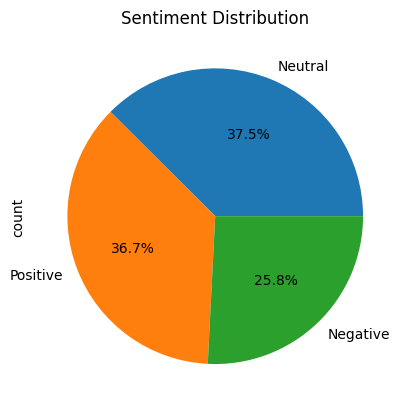

In [40]:
sentiment_counts = pdf['sentiment'].value_counts()
sentiment_counts.plot.pie(autopct='%.1f%%')
plt.title('Sentiment Distribution')
plt.show()

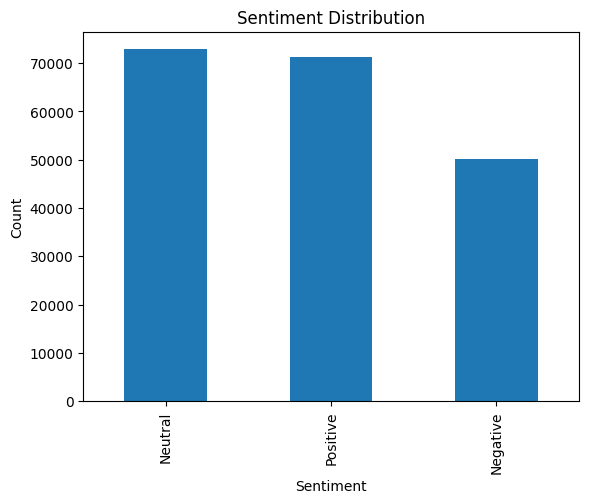

In [41]:
sentiment_counts = pdf['sentiment'].value_counts()
sentiment_counts.plot.bar()
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

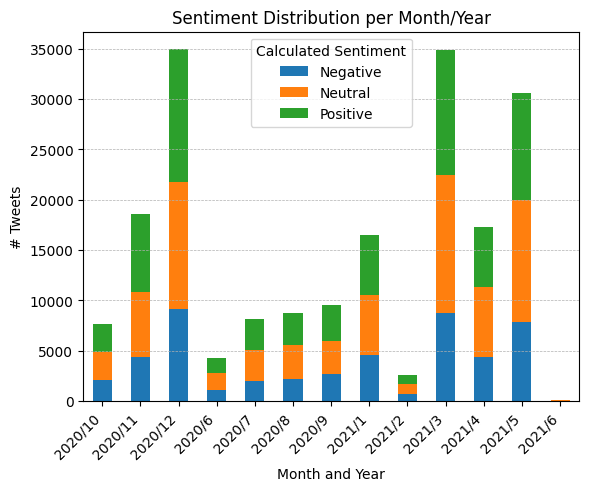

In [84]:
result_df = pdf.groupby(['year', 'month', 'sentiment'])['sentiment'].count().unstack('sentiment').fillna(0)
ax = result_df.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution per Month/Year')
plt.xlabel('Month and Year')
plt.ylabel('# Tweets')
plt.xticks(rotation=45, ha="right")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
xtick_labels = ['{}/{}'.format(int(year), int(month)) for year, month in grouped_df.index]
ax.set_xticklabels(xtick_labels)
ax.legend(title='Calculated Sentiment')
plt.show()

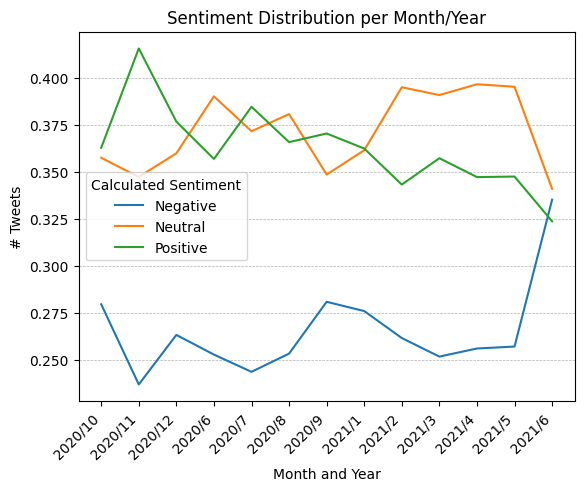

In [107]:
result_df = pdf.groupby(['year', 'month', 'sentiment'])['sentiment'].count().unstack('sentiment').fillna(0)
result_df = result_df.div(result_df.sum(axis=1), axis=0)
ax = result_df.plot(kind='line')
plt.title('Sentiment Distribution per Month/Year')
plt.xlabel('Month and Year')
plt.ylabel('# Tweets')
plt.xticks(rotation=45, ha="right")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.xaxis.set_major_locator(mtick.FixedLocator([0,1,2,3,4,5,6,7,8,9,10,11,12]))
xtick_labels = ['{}/{}'.format(int(year), int(month)) for year, month in result_df.index]
ax.set_xticklabels(xtick_labels)
ax.legend(title='Calculated Sentiment')
plt.show()